In [95]:
import os
import numpy as np
import torch
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Binarizer
from time import time
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler, BatchSampler, RandomSampler
from torch import nn, optim

from torch.utils.tensorboard import SummaryWriter

from functools import reduce

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Dataloader + downloading dataset

In [ ]:
class CustomBatchSampler(Sampler):
    r"""Wraps another sampler to yield a mini-batch of indices.

    Args:
        sampler (Sampler): Base sampler.
        batch_size (int): Size of mini-batch.
        drop_last (bool): If ``True``, the sampler will drop the last batch if
            its size would be less than ``batch_size``

    Example:
        >>> list(BatchSampler(SequentialSampler(range(10)), batch_size=3, drop_last=False))
        [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9]]
        >>> list(BatchSampler(SequentialSampler(range(10)), batch_size=3, drop_last=True))
        [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
    """

    def __init__(self, sampler, batch_size, drop_last, already_labeled):
        if not isinstance(sampler, Sampler):
            raise ValueError("sampler should be an instance of "
                             "torch.utils.data.Sampler, but got sampler={}"
                             .format(sampler))
        if not isinstance(batch_size, _int_classes) or isinstance(batch_size, bool) or \
                batch_size <= 0:
            raise ValueError("batch_size should be a positive integer value, "
                             "but got batch_size={}".format(batch_size))
        if not isinstance(drop_last, bool):
            raise ValueError("drop_last should be a boolean value, but got "
                             "drop_last={}".format(drop_last))
        self.sampler = sampler
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.already_labeled = already_labeled

    def __iter__(self):
        batch = []
        labeled = []
        unlabeled = []
        for idx in self.sampler:
            if 
            batch.append(idx)
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        if len(batch) > 0 and not self.drop_last:
            yield batch

    def __len__(self):
        if self.drop_last:
            return len(self.sampler) // self.batch_size
        else:
            return (len(self.sampler) + self.batch_size - 1) // self.batch_size

In [134]:
DOWNLOAD = False
TRAIN_VAL_SPLIT = 0.9
batch_size = 599  # will result in 100 minibatches

root = './resources/mnist'
if not os.path.exists(root):
    os.mkdir(root)
    
transform = transforms.Compose([transforms.ToTensor(),
#                                 transforms.Normalize((0.0,), (1.0,))
                               ])

# Flatten the images into a vector
flatten = lambda x: transforms.ToTensor()(x).view(28**2)

full_train_set = datasets.MNIST(root=root, download=DOWNLOAD, train=True, transform=transform)
test_set = datasets.MNIST(root=root, download=DOWNLOAD, train=False, transform=transform)

num_full_train = len(full_train_set)
train_size = int(TRAIN_VAL_SPLIT * num_full_train)
val_size = num_full_train - train_size
train_set, val_set = torch.utils.data.random_split(full_train_set, [train_size, val_size])

# The digit classes to use
classes = [0,1,2,3,4,5,6,7,8,9]

def get_labeled_indices(labels, classes, n_each=10):
    labeled_indices = []
    for c in classes:
        # get first N indices of a given label
        labeled_indices.extend(list(np.asarray(reduce(lambda x, y: x | y, [labels.numpy() == c])).nonzero()[0][:n_each]))

    labeled_indices = np.array(labeled_indices)
    np.random.shuffle(labeled_indices)
    return labeled_indices

def stratified_sampler(labels, excluded_indices=np.array([], dtype=bool)):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    
    mask = np.ones(len(indices), dtype=bool)
    if excluded_indices.size != 0:
        mask[excluded_indices] = False
    
    indices = indices[mask]
    np.random.shuffle(indices)  # in-place shuffling
#     indices = torch.from_numpy(indices[mask,...])
    return SubsetRandomSampler(indices)


labeled_indices = get_labeled_indices(full_train_set.train_labels, classes, n_each=10)

train_loader = torch.utils.data.DataLoader(dataset=full_train_set,
                                           batch_size=batch_size,
                                           sampler=stratified_sampler(full_train_set.train_labels, labeled_indices),
#                                            shuffle=True
                                          )

val_loader = torch.utils.data.DataLoader(dataset=test_set,
                                         batch_size=batch_size,
#                                          sampler=stratified_sampler(test_set.test_labels),
                                         shuffle=True
                                        )

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=batch_size,
                                          sampler=stratified_sampler(test_set.test_labels)
#                                           shuffle=False
                                         )

print('Training samples: {}'.format(len(train_set)))
print('Validation samples: {}'.format(len(val_set)))
print('Test samples: {}'.format(len(test_set)))
print(len(train_loader))

Training samples: 54000
Validation samples: 6000
Test samples: 10000
100


In [75]:
def make_one_hot_labels(y, n_classes=10):
    """One-hot encoding of labels"""
    
    one_hot = np.zeros((n_classes, y.shape[0]))
    for i in range(y.shape[0]):
        one_hot[y[i], i] = 1
    return one_hot

In [135]:
len(train_set), len(val_set), len(full_train_set), len(train_loader)

(54000, 6000, 60000, 100)

In [110]:
labeled_indices

array([120,  36,  69,  12,  29,   5,  44,  83,  86, 132,  60,  37,  91,
        46,  75,  49,   2, 117, 138,  85,  24, 125,  16, 122,  27,  53,
        39,  34,  51,  55,  97,  15,  50, 145,  65,  41,  42,  14,  22,
        32,  71,   4,   9,  56,  96,  28, 109,  33,  57, 173,  79,  82,
        18,  43,  52,  94,  30,  11,   8, 100,  90,  38,  68,  25,  66,
        67,  61,  59,  84,  74,  19,  48,  64,   3,  13,   6,  54,   0,
        62,  80,  73,  89,  26,  76,  40,  21,  31, 137,   7,  45,  47,
        58,  63,   1,  23,  20,  10,  70,  35,  17])

In [146]:
full_train_set[120][1]

2

In [137]:
next(iter(train_loader))[0].shape

torch.Size([599, 1, 28, 28])

In [155]:
x_labeled, y_labeled = full_train_set[120]
x_labeled = x_labeled.unsqueeze(0)
x_unlabeled, y_unlabeled = next(iter(train_loader))

x_labeled.shape, x_unlabeled.shape

(torch.Size([1, 1, 28, 28]), torch.Size([599, 1, 28, 28]))

In [4]:
len(train_set.indices), len(train_loader)

(54000, 938)

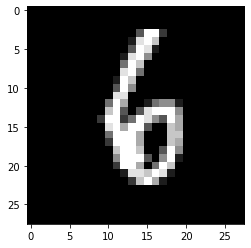

In [5]:
pom, _ = next(iter(train_loader))
pom.shape
plt.imshow(pom[0].view(28,28).numpy(), cmap='gist_gray')

## Inspecting the first iteration of images and labels

In [6]:
# get iteration of images and labels to find out its shape
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [7]:
# Minimum and maximum value in the first image (pixel range)
min(images[0].view(-1)), max(images[0].view(-1))

(tensor(0.), tensor(1.))

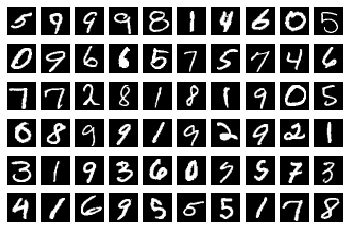

In [8]:
# display 60 images from current iteration
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gist_gray')

# M2 implementation

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

num_features = 28*28
latent_features = 50

class M2Net(nn.Module):
    
    def __init__(self, latent_features=50, n_classes=10):
        super(M2Net, self).__init__()
        
        self.latent_features = latent_features
        
        self.label_encoder = nn.Sequential(
            nn.Linear(num_features, 500),
            nn.Softplus(),
            nn.Linear(500, n_classes)
        )
        
        self.z_encoder = nn.Sequential(
            nn.Linear(num_features+n_classes, 500),
            nn.Softplus(),
            nn.Linear(500, 2*latent_features)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_features+n_classes, 500),
            nn.Softplus(),
            nn.Linear(500, num_features)
        )
        
    def reparametrization_trick(self, mu, log_var):
        with torch.no_grad():
            batch_size = mu.size(0)
            epsilon = torch.randn(batch_size, self.latent_features).to(device)
        # log(sigma^2) = log_var  =>  e^(log_var) = sigma^2  =>  sigma = e^(log_var / 2)
        sigma = torch.exp(log_var / 2)
        z = mu + sigma * epsilon
        return z
        
    def forward(self, x, y_one_hot=None):
        initial_shape = x.shape
        x = x.view(initial_shape[0], -1)  # flatten the input
        
        y_hat = self.label_encoder(x)  # ??? should this be softmaxed ???
        if y_one_hot:
            x_y = torch.cat([x, y_one_hot], dim=1)
        else:
            x_y = torch.cat([x, y_hat], dim=1)
#         print(x.shape, y.shape, x_y.shape)
#         print(y_hat)
        q_mu, q_log_var = torch.chunk(self.z_encoder(x_y), 2, dim=-1)
        # Make sure that the log variance is positive
#         log_var = F.softplus(log_var)
        z = self.reparametrization_trick(q_mu, q_log_var)  # sample from mu + sigma * epsilon, where epsilon ~ N(0,1)
        
        if y_one_hot:
            z_y = torch.cat([z, y_one_hot], dim=1)
        else:
            z_y = torch.cat([z, y_hat], dim=1)
        x_hat = F.sigmoid(self.decoder(z_y))
        x_hat = x_hat.view(initial_shape)
        return x_hat, q_mu, q_log_var, z, y_hat
    
net = M2Net(latent_features=latent_features).to(device)
print(net)

M2Net(
  (label_encoder): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=500, out_features=10, bias=True)
  )
  (z_encoder): Sequential(
    (0): Linear(in_features=794, out_features=500, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=500, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=60, out_features=500, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=500, out_features=784, bias=True)
  )
)


In [34]:
pom_x = torch.Tensor([[1,1,1],[2,2,2]])
pom_label = torch.Tensor([0,1]).unsqueeze(1)
print(pom_x.shape, pom_label.shape)
# pom_label
torch.cat([pom_x, pom_label], dim=1)

torch.Size([2, 3]) torch.Size([2, 1])


tensor([[1., 1., 1., 0.],
        [2., 2., 2., 1.]])

In [65]:
import torch.optim as optim

def ELBO_loss(x_hat, x, mu, log_var, y_hat, y, bernoulli=False):
#     print("x_hat: {}; x: {}; mu: {}; log_var: {}; y_hat: {}; y: {}".format(x_hat.shape, x.shape, mu.shape, log_var.shape, 
#                                                                            y_hat.shape, y.shape))
    # log p(x)
    log_px_batch = -F.binary_cross_entropy(x_hat, x, reduction='none') # dimension [batch, [orig_image_dims]]
    # Sum over features
    log_px_batch = log_px_batch.view(log_px_batch.size(0), -1).sum(1)
    
    # log p(y)
    y_hat_categorical = y_hat.max(dim=1)[1]
    pom_loss = nn.CrossEntropyLoss(reduction='none')
    log_py_batch = -pom_loss(y_hat, y)
    
    # log p(x) = log p(x) + p(y)
    log_px_batch += log_py_batch
    
    # log p(z)
    log_pz = -0.5 * torch.sum(np.log(2 * np.pi) + (mu**2 + torch.exp(log_var)), dim=1)
    
    # log q(z|x)
    log_qz = -0.5 * torch.sum(np.log(2 * np.pi) + 1 + log_var, dim=1)
    
    # the evidence lower bound objective (ELBO)
    # use mean over batch
    elbo = torch.mean(log_px_batch) + torch.mean(log_pz) - torch.mean(log_qz)
    return -elbo#, kl.sum()

# loss_function = nn.MSELoss()
loss_function = ELBO_loss
optimizer = optim.Adam(net.parameters(), lr=0.001)

### Test the forward pass

In [44]:
# test the forward pass
images, labels = next(iter(train_loader))
images = images.to(device)
print(images.shape)
outputs, mu, log_var, z, y_hat = net(images)
print(outputs.shape)
print("x_hat: {}; mu: {}; log_var: {}; z: {}; y_hat: {}".format(outputs.shape, mu.shape, log_var.shape,
                                                                z.shape, y_hat.shape))

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
x_hat: torch.Size([64, 1, 28, 28]); mu: torch.Size([64, 50]); log_var: torch.Size([64, 50]); z: torch.Size([64, 50]); y_hat: torch.Size([64, 10])


/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [45]:
# min and max value of output images (pixel values)
min(outputs.view(-1)), max(outputs.view(-1))

(tensor(0.1583, grad_fn=<SelectBackward>),
 tensor(0.8470, grad_fn=<SelectBackward>))

In [62]:
# Example loss function and output dimensions
loss = loss_function(outputs, images, mu, log_var, y_hat, labels, bernoulli=False)
print('log var shape:', log_var.shape)
print('mu shape:', mu.shape)
print('loss value:', loss)
# print('kl value', kl)

x_hat: torch.Size([64, 1, 28, 28]); x: torch.Size([64, 1, 28, 28]); mu: torch.Size([64, 50]); log_var: torch.Size([64, 50]); y_hat: torch.Size([64, 10]); y: torch.Size([64])
log var shape: torch.Size([64, 50])
mu shape: torch.Size([64, 50])
loss value: tensor(572.6650, grad_fn=<NegBackward>)


### Save batch of images and network graph to file for displaying in tensorboard

In [ ]:
# Save batch of images and network graph to file for displaying in tensorboard
tb = SummaryWriter()

network = Net()
grid = torchvision.utils.make_grid(images)

tb.add_image('images', grid)
tb.add_graph(network, images)
tb.close()

## Train the VAE

In [66]:
from IPython.display import Image, display, clear_output
from sklearn.decomposition import PCA
# train the network
TF_LOG = False
BERNOULLI = False
train_loss, train_kl = [], []
valid_loss, valid_kl = [], []

print("Using device:", device)

if TF_LOG:
    tb = SummaryWriter()

for epoch in range(2):
    batch_loss, batch_kl = [], []
    net.train()
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # train on labeled data
        x_labeled, y_labeled = full_train_set[labeled_indices[i]]
        x_labeled = x_labeled.unsqueeze(0)
        # for labeled case, use net(inputs, make_one_hot_labels(labels))
        x_hat, mu, log_var, z, y_hat = net(x_labeled, make_one_hot_labels(y_labeled))
        loss_l = loss_function(x_hat, x_labeled, mu, log_var, y_hat, y_labeled)
        
        # train on unlabeled data
        x_unlabeled, y_unlabeled = data[0].to(device), data[1].to(device)
        
        # forward + backward + optimize
        x_hat, mu, log_var, z, y_hat = net(x_unlabeled)
        loss_u = loss_function(x_hat, x_unlabeled, mu, log_var, y_hat, y_unlabeled) #TODO: should not use y_unlabeled
        
        loss = loss_l + loss_u # + alpha * E_{p_l (x,y)} [− log q_φ (y|x)]
        
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
#         batch_kl.append(kl.item())
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    
    train_loss.append(np.mean(batch_loss))
#     train_kl.append(np.mean(batch_kl))
    
    with torch.no_grad():
        net.eval()
        batch_loss, batch_kl = [], []
        
#         for data in test_loader:
        data = next(iter(test_loader))
        inputs, labels = data[0].to(device), data[1].to(device)

        x_hat, mu, log_var, z, y_hat = net(inputs)

        loss = loss_function(x_hat, inputs, mu, log_var, y_hat, labels)
        batch_loss.append(loss.item())
#         batch_kl.append(kl.item())
            
        valid_loss.append(np.mean(batch_loss))
#         valid_kl.append(np.mean(batch_kl))
        
        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        inputs = inputs.to("cpu")
        x_hat = x_hat.to("cpu")
        z = z.detach().to("cpu").numpy()
    
    if TF_LOG:
        tb.add_scalar('Training loss', train_loss[-1], epoch)
        tb.add_scalar('Training KL divergence', train_kl[-1], epoch)
        tb.add_scalar('Validation loss', valid_loss[-1], epoch)
        tb.add_scalar('Validation KL divergence', valid_kl[-1], epoch)


if TF_LOG:
    tb.close()
# print('Finished training!')

Using device: cpu
[1,   100] loss: 202.604
[1,   200] loss: 133.559
[1,   300] loss: 115.739
[1,   400] loss: 108.886
[1,   500] loss: 105.443
[1,   600] loss: 101.813
[1,   700] loss: 100.820
[1,   800] loss: 98.576
[1,   900] loss: 97.631
[2,   100] loss: 94.693
[2,   200] loss: 93.612
[2,   300] loss: 93.008
[2,   400] loss: 92.475
[2,   500] loss: 92.147
[2,   600] loss: 91.403
[2,   700] loss: 90.623
[2,   800] loss: 90.018
[2,   900] loss: 89.619


### Train & validation loss

[Text(0, 0.5, 'loss'),
 Text(0.5, 0, 'epoch'),
 Text(0.5, 1.0, 'Training & validation loss')]

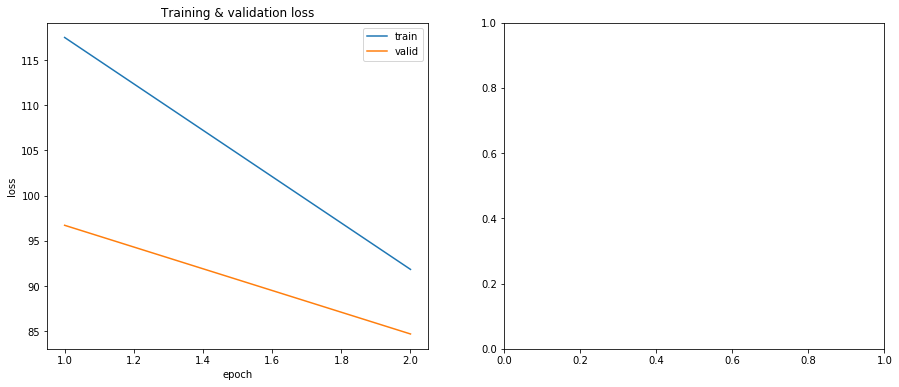

In [67]:
net.eval()

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
x = range(1, epoch + 2)
sns.lineplot(x=x, y=train_loss, ax=ax[0], label="train")
sns.lineplot(x=x, y=valid_loss, ax=ax[0], label="valid")
ax[0].set(xlabel="epoch",
          ylabel="loss",
          title="Training & validation loss")

# sns.lineplot(x=x, y=train_kl, ax=ax[1], label="train")
# sns.lineplot(x=x, y=valid_kl, ax=ax[1], label="valid")
# ax[1].set(xlabel="epoch",
#           ylabel="KL",
#           title="Training & validation KL")

### Latent space visualization

In [72]:
with torch.no_grad():
    net.eval()
    
    it = iter(test_loader)
    images, labels = next(it)
    x = images.view(images.shape[0], -1)
    latent_y = net.label_encoder(x)
    net.
    print(latent_y.max(dim=1)[1])
    print(labels)

tensor([6, 8, 2, 0, 4, 4, 2, 5, 1, 0, 3, 2, 3, 7, 7, 0, 3, 8, 8, 2, 6, 5, 0, 2,
        1, 9, 3, 4, 7, 8, 0, 7, 9, 5, 5, 4, 7, 7, 7, 9, 3, 1, 9, 5, 7, 2, 6, 1,
        7, 7, 3, 1, 2, 9, 3, 2, 1, 1, 1, 8, 1, 8, 7, 9])
tensor([6, 3, 2, 6, 4, 4, 2, 5, 1, 0, 3, 2, 3, 7, 7, 5, 8, 8, 3, 2, 6, 5, 6, 2,
        1, 9, 2, 4, 7, 3, 0, 7, 7, 5, 3, 4, 7, 7, 7, 9, 3, 1, 9, 5, 7, 2, 6, 1,
        7, 7, 8, 1, 2, 9, 3, 2, 1, 1, 1, 8, 1, 8, 7, 9])


# TODO:

* Load 1000 labeled data and the rest of unlabeled (inspiration in *learn_yz_x_ss.py*)
* Run the model on all the data but use different loss functions for labeled data and for unlabbeled data